In [2]:
#Import the libraries
import os, random
import numpy as np
import pandas as pd
import tensorflow as tf
import librosa as lib
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential
import IPython.display as ipd


Labels: ['left', 'one', 'right', 'stop', 'three', 'two']


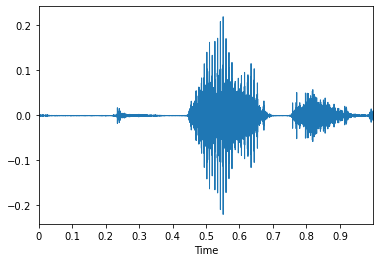

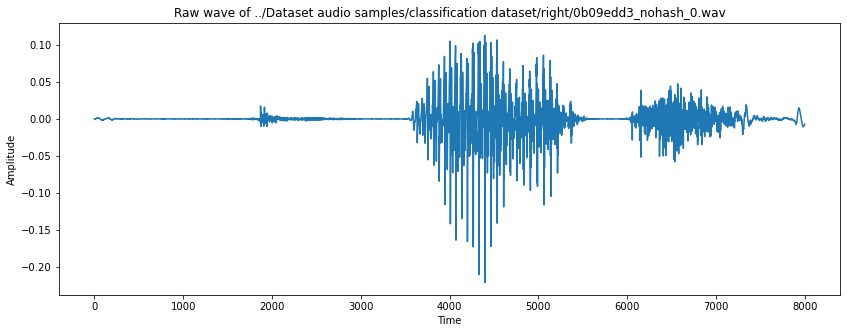

In [3]:
#Set the audio samples file path
audio_path  = '../Dataset audio samples/classification dataset'
test_audio_path = '../Dataset audio samples/classification test samples/'
labels = os.listdir(audio_path)
print('Labels:', labels)

#Perform EDA and data visulaization
sample, sample_rate = lib.load(audio_path + '/right/0b09edd3_nohash_0.wav', sr=8000)

lib.display.waveplot(sample,sr=sample_rate)
ipd.Audio(audio_path + '/right/0b09edd3_nohash_0.wav')

fig = plt.figure(figsize=(14, 5))
plt.title('Raw wave of ' + audio_path + '/right/0b09edd3_nohash_0.wav')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(sample)

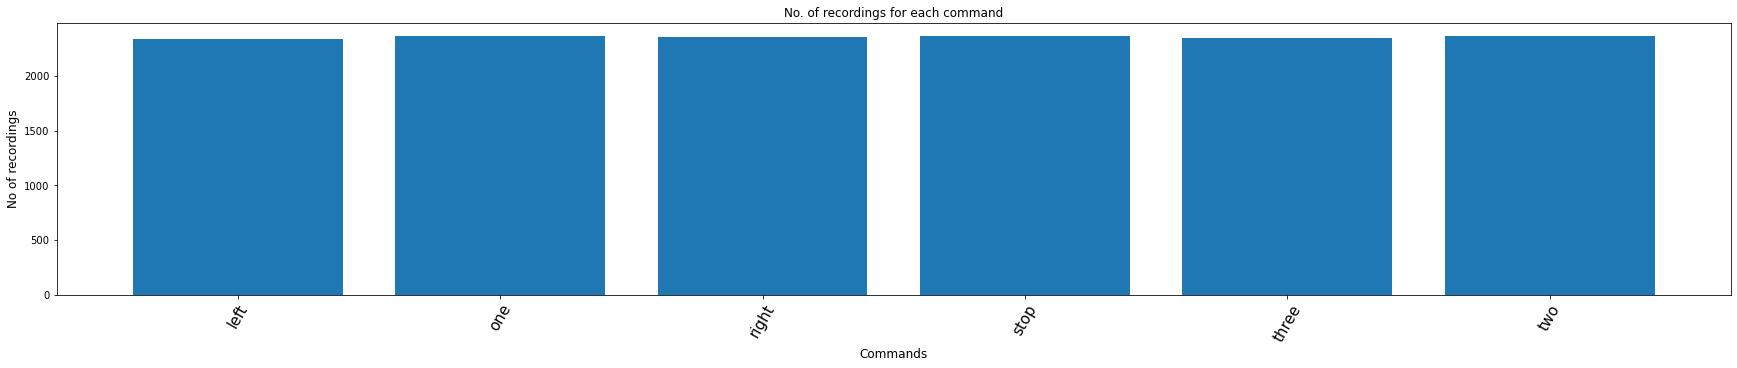

In [4]:
#Plotting the count of recordings for each label

no_of_recordings=[]
for label in labels:
    no_of_recordings.append(len([f for f in os.listdir(audio_path + '/' + label) if f.endswith('.wav')]))
    
#plot
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=12)
plt.ylabel('No of recordings', fontsize=12)
plt.xticks(index, labels, fontsize=15, rotation=60)
plt.title('No. of recordings for each command')
plt.show()

In [5]:
print(no_of_recordings)

[2343, 2365, 2357, 2366, 2351, 2368]


(array([1.0000e+01, 1.8000e+01, 2.9000e+01, 7.4000e+01, 6.2000e+01,
        1.1100e+02, 1.9800e+02, 2.4900e+02, 3.1200e+02, 1.3087e+04]),
 array([0.41800454, 0.47620408, 0.53440363, 0.59260317, 0.65080272,
        0.70900227, 0.76720181, 0.82540136, 0.88360091, 0.94180045,
        1.        ]),
 <BarContainer object of 10 artists>)

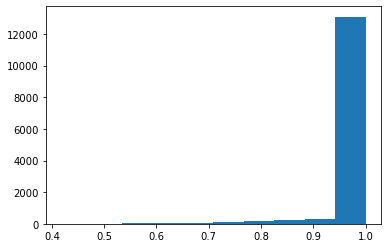

In [5]:
#Plotting histogram of duration of each recording
duration=[]
for l in labels:
    waves = [f for f in os.listdir(audio_path+'/' + l) if f.endswith('.wav')]
    for w in waves:
        s,sr = lib.load(audio_path+'/'+l+'/'+w)
        duration.append(len(s)/sr)
        
plt.hist(np.array(duration))

In [6]:
#Audio signal preprocessing
# 1. Resampling (8000)
# 2. Remove audio samples < 1s
# 3. Creating X and Y arrays of audio samples and its lables

#Create an array of independant variable
x_audio=[]
#Create an array of dependant variable
y_label=[]
x_sample_rate = 8000

for label in labels:
    audios = [f for f in os.listdir(audio_path+'/' + label) if f.endswith('.wav')]
    for aud in audios:
        aud_sample,aud_rate = lib.load(audio_path+'/'+label+'/'+aud, sr=x_sample_rate)
        #resample
        #aud_sample = lib.resample(aud_sample, sample_rate, 8000)
        if len(aud_sample) == x_sample_rate:
            x_audio.append(aud_sample)
            y_label.append(label)


In [7]:
df = pd.DataFrame(list(zip(x_audio, y_label)), columns =['Audio', 'Label'])
df.head()

,Audio,Label
0,"[3.519407e-05, 2.2681637e-05, 8.5668515e-05, 0...",left
1,"[-0.0007129329, -0.0032121914, -0.0008934916, ...",left
2,"[-0.0005274635, -0.0007533008, -0.0007641713, ...",left
3,"[0.003849275, 0.0059264293, 0.0072958367, 0.00...",left
4,"[0.00013220317, 0.00013587563, 1.6315247e-05, ...",left


In [8]:
df = df.sample(frac=1)
x_audio_ds = df.iloc[:,0].values
y_audio_label=df.iloc[:,1].values
df.head()

,Audio,Label
10914,"[0.029169999, 0.043154664, 0.03819058, 0.04135...",two
1875,"[0.0018153464, 0.0040009115, 0.0034991067, 0.0...",left
11469,"[0.0001409523, 8.554835e-05, 0.00050013216, 0....",two
9257,"[-0.00010571442, -4.16006e-05, 0.00019957805, ...",three
995,"[0.006955558, 0.012204045, 0.013376621, 0.0137...",left


In [9]:
print(x_audio_ds.shape, y_audio_label.shape)
print(x_audio_ds[4])
print(y_audio_label[4])

(12837,) (12837,)
[ 0.00695556  0.01220405  0.01337662 ...  0.00725323 -0.01029613
 -0.00326916]
left


In [10]:
#Audio feature extraction for all audio files
x_audio_feature=[]

for aud in (x_audio_ds):
    mfcc = (lib.feature.mfcc(aud, x_sample_rate, n_mfcc = 40))
    x_audio_feature.append(np.mean(mfcc.T,axis=0))

In [11]:
#One-hot encoding of label data for multiclass category
#ct=ColumnTransformer(transformers=[('encoder', OneHotEncoder(sparse=False), [0])], remainder='passthrough')
#y_label = np.array(ct.fit_transform(np.array(y_label).reshape(-1,1)))
lb = LabelBinarizer()
y_audio_label = (lb.fit_transform(y_audio_label))
print(y_audio_label)

[[0 0 0 0 0 1]
 [1 0 0 0 0 0]
 [0 0 0 0 0 1]
 ...
 [0 0 1 0 0 0]
 [0 0 0 0 0 1]
 [0 1 0 0 0 0]]


In [12]:
print(y_audio_label.shape)

(12837, 6)


In [13]:
#Split the dataset into train and test data
x_audio_feature=np.array(x_audio_feature)
x_train, x_test, y_train, y_test = train_test_split(x_audio_feature, y_audio_label, test_size=0.2, random_state=0)

In [14]:
print(x_train.shape)
print(y_train.shape)

(10269, 40)
(10269, 6)


In [15]:
#Perform feature scaling
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

In [21]:
#Build ANN model for audio classification
ann = Sequential()

#1st layer
ann.add(Dense(units=200, activation='relu', input_shape=(40,)))
ann.add(Dropout(0.1))
#2nd layer
ann.add(Dense(units=200, activation='relu'))
ann.add(Dropout(0.1))
#3rd layer
ann.add(Dense(units=200, activation='relu'))
ann.add(Dropout(0.2))
#Last layer
ann.add(Dense(units=6, activation='softmax'))
ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary
ann.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 200)               8200      
_________________________________________________________________
dropout_6 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 200)               40200     
_________________________________________________________________
dropout_7 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 200)               40200     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 6)                

In [22]:
#Train the model
x_train=np.asarray(x_train).astype(np.float32)
y_train=np.asarray(y_train).astype(np.float32)
ann.fit(x_train, y_train, batch_size=32, epochs=150)

#Model accuracies
print('Training accuracy: ', ann.evaluate(x_train, y_train, verbose=0))
print('Testing accuracy: ', ann.evaluate(x_test, y_test, verbose=0))

Epoch 1/150
321/321 [==============================] - 1s 2ms/step - loss: 1.3364 - accuracy: 0.4678
Epoch 2/150
321/321 [==============================] - 1s 2ms/step - loss: 1.1239 - accuracy: 0.5677
Epoch 3/150
321/321 [==============================] - 1s 2ms/step - loss: 1.0436 - accuracy: 0.6045
Epoch 4/150
321/321 [==============================] - 1s 2ms/step - loss: 0.9840 - accuracy: 0.6248
Epoch 5/150
321/321 [==============================] - 1s 2ms/step - loss: 0.9324 - accuracy: 0.6441
Epoch 6/150
321/321 [==============================] - 1s 2ms/step - loss: 0.8873 - accuracy: 0.6672
Epoch 7/150
321/321 [==============================] - 1s 2ms/step - loss: 0.8403 - accuracy: 0.6843
Epoch 8/150
321/321 [==============================] - 1s 2ms/step - loss: 0.8003 - accuracy: 0.7010
Epoch 9/150
321/321 [==============================] - 1s 2ms/step - loss: 0.7624 - accuracy: 0.7082
Epoch 10/150
321/321 [==============================] - 1s 2ms/step - loss: 0.7244 - accura

321/321 [==============================] - 1s 2ms/step - loss: 0.1756 - accuracy: 0.9375
Epoch 81/150
321/321 [==============================] - 1s 2ms/step - loss: 0.1714 - accuracy: 0.9387
Epoch 82/150
321/321 [==============================] - 1s 2ms/step - loss: 0.1633 - accuracy: 0.9425
Epoch 83/150
321/321 [==============================] - 1s 2ms/step - loss: 0.1764 - accuracy: 0.9386
Epoch 84/150
321/321 [==============================] - 1s 2ms/step - loss: 0.1660 - accuracy: 0.9403
Epoch 85/150
321/321 [==============================] - 1s 2ms/step - loss: 0.1771 - accuracy: 0.9379
Epoch 86/150
321/321 [==============================] - 1s 2ms/step - loss: 0.1697 - accuracy: 0.9438
Epoch 87/150
321/321 [==============================] - 1s 2ms/step - loss: 0.1527 - accuracy: 0.9487
Epoch 88/150
321/321 [==============================] - 1s 2ms/step - loss: 0.1591 - accuracy: 0.9448
Epoch 89/150
321/321 [==============================] - ETA: 0s - loss: 0.1661 - accuracy: 0.94

In [118]:
#Predict using ann model
res=ann.predict(x_test)
print(lb.inverse_transform((res[0].reshape(1,-1)))[0])
print('Accuracy score: ', accuracy_score(lb.inverse_transform(y_test),lb.inverse_transform(res)))

three
Accuracy score:  0.631619937694704


In [127]:
import sounddevice as sd
from scipy.io.wavfile import write

def record_audio():
    rate = 8000  # Sample rate
    seconds = 1  # Duration of recording

    my_audio = sd.rec(int(seconds * rate), samplerate=rate, channels=1)
    sd.wait()  # Wait until recording is finished
    write(test_audio_path + 'test.wav', rate, my_audio)  # Save as WAV file 
    return 'test.wav'
    
def predict_audio(filename):
    filepath = test_audio_path + filename
    audio, sam = lib.load(filepath, sr=8000)
    mfcc = lib.feature.mfcc(y=audio, sr=sam, n_mfcc=40)
    mfcc_scaled = np.mean(mfcc.T,axis=0)

    mfcc_scaled=mfcc_scaled.reshape(1,-1)
    audio_predicted=ann.predict(sc.transform(mfcc_scaled))
    audio_class = lb.inverse_transform(audio_predicted) 
    print('Your audio (' + filename + ') belongs to the label: ', audio_class[0].upper())

In [128]:
#Classify a random audio file from the unlabeled test folder
file = random.choice([f for f in os.listdir(test_audio_path)])
predict_audio(file)
ipd.Audio(test_audio_path+file, autoplay=True)

Your audio (left (3).wav) belongs to the label:  TWO


In [122]:
#Classify a live spoken audio through microphone
predict_audio(record_audio())
ipd.Audio(test_audio_path+'test.wav', autoplay=True)

Your audio (test.wav) belongs to the label:  ONE


In [ ]:
#Evaluating the model
def build_ann():
    #Build ANN model for audio classification
    ann = Sequential()
    #1st layer
    ann.add(Dense(units=200, activation='relu', input_shape=(40,)))
    ann.add(Dropout(0.2))
    #2nd layer
    ann.add(Dense(units=200, activation='relu'))
    ann.add(Dropout(0.2))
    #3rd layer
    ann.add(Dense(units=200, activation='relu'))
    ann.add(Dropout(0.2))
    #Last layer
    ann.add(Dense(units=6, activation='softmax'))
    ann.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return ann

ann = KerasClassifier(build_fn=build_ann, batch_size=40, epochs=100)
accuracies = cross_val_score(estimator=ann, X=x_train, y=y_train, cv=10, n_jobs=-1)